In [1]:
import pandas as pd
import pypsa
from scripts.__helpers import replace_su, average_every_nhours
import numpy as np
import os

In [2]:
def get_flow_based_groupers(PTDF_zone, PTDF_DC, PTDF_AHC):

    zones = PTDF_zone.columns

    AC = n.links.query("(carrier == 'AC') & (bus0 in @zones) & (bus1 in @zones)")
    AC_bus0 = AC.bus0.copy()
    AC_bus0.name = "bus"
    AC_bus1 = AC.bus1.copy()
    AC_bus1.name = "bus"
    
    DC = pd.Series(PTDF_DC.columns + "-DC", PTDF_DC.columns)
    DC = DC.to_frame("direct")
    DC["opposite"] = [i.split("-")[1] + "-" + i.split("-")[0] + "-DC" for i in DC.index]
    grouper_DC_direct = pd.Series(DC.index, DC.direct, name="name")
    grouper_DC_opposite = pd.Series(DC.index, DC.opposite, name="name")
    grouper_DC_direct.index.name="name"
    grouper_DC_opposite.index.name="name"
    
    
    AHC = PTDF_AHC.columns
    
    AHC_matching = pd.Series(index  = AHC)
    
    for i in AHC:
        matched_links = [j for j in n.links.index if "-".join(j.split("-")[:2]) ==i]
        if len(matched_links) >0:
            AHC_matching.loc[i] = matched_links[0]
    
    AHC_matching.dropna(inplace=True)
    AHC_matching = AHC_matching.to_frame("direct")
    
    for i in AHC_matching.index:
        direct_link = AHC_matching.loc[i, "direct"]
    
        bus0, bus1, carrier = direct_link.split("-")
        
        opposite = "{bus1}-{bus0}-{carrier}".format(bus0=bus0, bus1=bus1, carrier=carrier)
        if opposite in n.links.index:
            AHC_matching.loc[i, "opposite"] = opposite
    
    if "UK00-FR00_1" in AHC_matching.index:
    
        AHC_matching.loc["UK00-FR00_1", "opposite"] = "UK00-FR00_1-DC"
        AHC_matching.loc["UK00-FR00_2", "opposite"] = "UK00-FR00_2-DC"
    
    grouper_AHC_direct = pd.Series(AHC_matching.index, AHC_matching.direct.values)
    grouper_AHC_direct.index.names = ["name"]
    
    grouper_AHC_opposite = pd.Series(AHC_matching.index, AHC_matching.opposite.values)
    grouper_AHC_opposite.index.names = ["name"]

    return AC_bus0, AC_bus1, AC, grouper_DC_direct, grouper_DC_opposite, DC, grouper_AHC_direct, grouper_AHC_opposite, AHC_matching, 


In [3]:
def PTDF_timeseries(PTDF, domain_assignment, nordic=False):
    
    if nordic==False:
        PTDF = PTDF.unstack(1).reindex(domain_assignment.values)
    else:
        PTDF = PTDF.unstack(1).reindex([1 for i in range(len(n.snapshots))])

    
    PTDF.index = n.snapshots
    PTDF = PTDF.stack(1)

    return PTDF

In [4]:
def prepare_PTDFs(PTDF, domain_assignment, nordic=False):
    
    PTDF_zone = PTDF_timeseries(PTDF["PTDF_SZ"], domain_assignment, nordic=nordic)
    PTDF_DC = PTDF_timeseries( PTDF["PTDF_EvFB"], domain_assignment, nordic=nordic)
    PTDF_AHC = PTDF_timeseries(PTDF["PTDF*_AHC,SZ"], domain_assignment, nordic=nordic)
    
    PTDF_zone.columns.name = "bus"
    PTDF_DC.columns.name = "name"
    PTDF_AHC.columns.name = "name"

    PTDF_zone.index.names=["snapshot", "CNEC"]
    PTDF_DC.index.names=["snapshot", "CNEC"]
    PTDF_AHC.index.names=["snapshot", "CNEC"]
    
    return PTDF_zone, PTDF_DC, PTDF_AHC


In [5]:
def prepare_for_uc():
    
    n.optimize.add_load_shedding(sign=1, marginal_cost=VOLL)

    """
    n.add(
        "Generator", 
        n.buses.query("carrier == 'electricity'").index + " gen-shedding", 
        bus = n.buses.query("carrier == 'electricity'").index, 
        p_nom = 1e6, 
        p_min_pu= -1,
        p_max_pu = 0,
        marginal_cost = -500,
        carrier="gen-shedding",
        ramp_limit_up = 1., 
        ramp_limit_down = 1.
    )
    """
    
    n.generators.ramp_limit_up = n.generators.ramp_limit_up.clip(upper=1.).fillna(1.)
    n.generators.ramp_limit_down = n.generators.ramp_limit_down.clip(upper=1.).fillna(1.)
    
    n.generators.shut_down_cost = n.generators.start_up_cost
    
    n.generators.up_time_before = n.generators.min_up_time
    n.generators.down_time_before = 0

In [6]:
def flow_based_market_coupling(n, snapshots):
    
    
    core = PTDF_zone_core.columns
    nordic = PTDF_zone_nordic.columns
    
    core_groupers = get_flow_based_groupers(PTDF_zone_core, PTDF_DC_core, PTDF_AHC_core)
    
    AC_core_bus0 = core_groupers[0]
    AC_core_bus1 = core_groupers[1]
    AC_core = core_groupers[2]
    grouper_DC_core_direct = core_groupers[3]
    grouper_DC_core_opposite = core_groupers[4] 
    DC_core = core_groupers[5]
    grouper_AHC_core_direct  = core_groupers[6]
    grouper_AHC_core_opposite = core_groupers[7]
    AHC_core_matching = core_groupers[8]

    nordic_groupers = get_flow_based_groupers(PTDF_zone_nordic, PTDF_DC_nordic, PTDF_AHC_nordic)
    
    AC_nordic_bus0 = nordic_groupers[0]
    AC_nordic_bus1 = nordic_groupers[1]
    AC_nordic = nordic_groupers[2]
    grouper_DC_nordic_direct= nordic_groupers[3]
    grouper_DC_nordic_opposite = nordic_groupers[4]
    DC_nordic = nordic_groupers[5]
    grouper_AHC_nordic_direct = nordic_groupers[6]
    grouper_AHC_nordic_opposite = nordic_groupers[7]
    AHC_nordic_matching = nordic_groupers[8]
    
    m = n.model
    
    net_position_zone_core = m.add_variables(coords=[snapshots, core], name="Bus-zonal_NP_core")
    net_position_AHC_core = m.add_variables(coords=[snapshots, AHC_core_matching.index], name="Link-AHC_NP_core")
    net_position_DC_core = m.add_variables(coords = [snapshots, DC_core.index], name="Link-DC_NP_core")
    
    net_position_zone_nordic = m.add_variables(coords=[snapshots, nordic], name="Bus-zonal_NP_nordic")
    net_position_AHC_nordic = m.add_variables(coords=[snapshots, AHC_nordic_matching.index], name="Link-AHC_NP_nordic")
    net_position_DC_nordic = m.add_variables(coords = [snapshots, DC_nordic.index], name="Link-DC_NP_nordic")
    
    m.add_constraints(
        net_position_zone_core  == (
            m["Link-p"].loc[:, AC_core.index].groupby(AC_core_bus0.to_xarray()).sum()
            - m["Link-p"].loc[:, AC_core.index].groupby(AC_core_bus1.to_xarray()).sum()
        ),
        name="Bus-zonal_net_position_core"
    )
    
    m.add_constraints(
        net_position_DC_core == (
            m["Link-p"].loc[:, DC_core.direct.values].groupby(grouper_DC_core_direct).sum() 
            - m["Link-p"].loc[:, DC_core.opposite.values].groupby(grouper_DC_core_opposite).sum() 
        ),
        name="Link-DC_net_position_core"
    )
    
    
    m.add_constraints(
        net_position_AHC_core == (
            m["Link-p"].loc[:, AHC_core_matching.direct.values].groupby(grouper_AHC_core_direct).sum()
            - m["Link-p"].loc[:, AHC_core_matching.opposite.values].groupby(grouper_AHC_core_opposite).sum()
        ), name="Link-AHC_net_position_core"
    )
    
    m.add_constraints(
        net_position_zone_nordic  == (
            m["Link-p"].loc[:, AC_nordic.index].groupby(AC_nordic_bus0.to_xarray()).sum()
            - m["Link-p"].loc[:, AC_nordic.index].groupby(AC_nordic_bus1.to_xarray()).sum()
        ),
        name="Bus-zonal_net_position_nordic"
    )
    
    m.add_constraints(
        net_position_DC_nordic == (
            m["Link-p"].loc[:, DC_nordic.direct.values].groupby(grouper_DC_nordic_direct).sum() 
            - m["Link-p"].loc[:, DC_nordic.opposite.values].groupby(grouper_DC_nordic_opposite).sum() 
        ),
        name="Link-DC_net_position_nordic"
    )
    
    
    m.add_constraints(
        net_position_AHC_nordic == (
            m["Link-p"].loc[:, AHC_nordic_matching.direct.values].groupby(grouper_AHC_nordic_direct).sum()
            - m["Link-p"].loc[:, AHC_nordic_matching.opposite.values].groupby(grouper_AHC_nordic_opposite).sum()
        ), name="Link-AHC_net_position_nordic"
    )
    
    m.add_constraints(
        (net_position_DC_core*PTDF_DC_core.loc[snapshots].stack().to_xarray()).sum("name")
        + (net_position_zone_core*PTDF_zone_core.loc[snapshots].stack().to_xarray()).sum("bus")
        + (net_position_AHC_core*PTDF_AHC_core.loc[snapshots].stack().to_xarray()).sum("name")
        <= RAM_core.loc[snapshots].stack().to_xarray(),
        name="CNEC_capacity_constraint_core"
    )
    
    m.add_constraints(
        (net_position_DC_nordic*PTDF_DC_nordic.loc[snapshots].stack().to_xarray()).sum("name")
        + (net_position_zone_nordic*PTDF_zone_nordic.loc[snapshots].stack().to_xarray()).sum("bus")
        + (net_position_AHC_nordic*PTDF_AHC_nordic.loc[snapshots].stack().to_xarray()).sum("name")
        <= RAM_nordic.loc[snapshots].stack().to_xarray(),
        name="CNEC_capacity_constraint_nordic"
    )


In [7]:
def flow_based_preoptimization(n, snapshots):

    m = n.model
    
    core = PTDF_zone_core.columns
    nordic = PTDF_zone_nordic.columns

    core_groupers = get_flow_based_groupers(PTDF_zone_core, PTDF_DC_core, PTDF_AHC_core)
    
    AC_core_bus0 = core_groupers[0]
    AC_core_bus1 = core_groupers[1]
    AC_core = core_groupers[2]
    grouper_DC_core_direct = core_groupers[3]
    grouper_DC_core_opposite = core_groupers[4] 
    DC_core = core_groupers[5]
    grouper_AHC_core_direct  = core_groupers[6]
    grouper_AHC_core_opposite = core_groupers[7]
    AHC_core_matching = core_groupers[8]

    nordic_groupers = get_flow_based_groupers(PTDF_zone_nordic, PTDF_DC_nordic, PTDF_AHC_nordic)
    
    AC_nordic_bus0 = nordic_groupers[0]
    AC_nordic_bus1 = nordic_groupers[1]
    AC_nordic = nordic_groupers[2]
    grouper_DC_nordic_direct= nordic_groupers[3]
    grouper_DC_nordic_opposite = nordic_groupers[4]
    DC_nordic = nordic_groupers[5]
    grouper_AHC_nordic_direct = nordic_groupers[6]
    grouper_AHC_nordic_opposite = nordic_groupers[7]
    AHC_nordic_matching = nordic_groupers[8]

    
    net_position_zone_core = m.add_variables(coords=[snapshots, core], name="Bus-zonal_NP_core")
    net_position_AHC_core = m.add_variables(coords=[snapshots, AHC_core_matching.index], name="Link-AHC_NP_core")
    net_position_DC_core = m.add_variables(coords = [snapshots, DC_core.index], name="Link-DC_NP_core")
    
    net_position_zone_nordic = m.add_variables(coords=[snapshots, nordic], name="Bus-zonal_NP_nordic")
    net_position_AHC_nordic = m.add_variables(coords=[snapshots, AHC_nordic_matching.index], name="Link-AHC_NP_nordic")
    net_position_DC_nordic = m.add_variables(coords = [snapshots, DC_nordic.index], name="Link-DC_NP_nordic")
    

    m.add_constraints(
        net_position_zone_core  == (
            m["Link-p"].loc[:, AC_core.index].groupby(AC_core_bus0.to_xarray()).sum()
            - m["Link-p"].loc[:, AC_core.index].groupby(AC_core_bus1.to_xarray()).sum()
        ),
        name="Bus-zonal_net_position_core"
    )
    
    m.add_constraints(
        net_position_DC_core == (
            m["Link-p"].loc[:, DC_core.direct.values].groupby(grouper_DC_core_direct).sum() 
            - m["Link-p"].loc[:, DC_core.opposite.values].groupby(grouper_DC_core_opposite).sum() 
        ),
        name="Link-DC_net_position_core"
    )
    
    
    m.add_constraints(
        net_position_AHC_core == (
            m["Link-p"].loc[:, AHC_core_matching.direct.values].groupby(grouper_AHC_core_direct).sum()
            - m["Link-p"].loc[:, AHC_core_matching.opposite.values].groupby(grouper_AHC_core_opposite).sum()
        ), name="Link-AHC_net_position_core"
    )
    
    m.add_constraints(
        net_position_zone_nordic  == (
            m["Link-p"].loc[:, AC_nordic.index].groupby(AC_nordic_bus0.to_xarray()).sum()
            - m["Link-p"].loc[:, AC_nordic.index].groupby(AC_nordic_bus1.to_xarray()).sum()
        ),
        name="Bus-zonal_net_position_nordic"
    )
    
    m.add_constraints(
        net_position_DC_nordic == (
            m["Link-p"].loc[:, DC_nordic.direct.values].groupby(grouper_DC_nordic_direct).sum() 
            - m["Link-p"].loc[:, DC_nordic.opposite.values].groupby(grouper_DC_nordic_opposite).sum() 
        ),
        name="Link-DC_net_position_nordic"
    )
    
    
    m.add_constraints(
        net_position_AHC_nordic == (
            m["Link-p"].loc[:, AHC_nordic_matching.direct.values].groupby(grouper_AHC_nordic_direct).sum()
            - m["Link-p"].loc[:, AHC_nordic_matching.opposite.values].groupby(grouper_AHC_nordic_opposite).sum()
        ), name="Link-AHC_net_position_nordic"
    )
  
    m.add_constraints(
        (net_position_DC_core*PTDF_DC_core.loc[snapshots].stack().to_xarray()).sum("name")
        + (net_position_zone_core*PTDF_zone_core.loc[snapshots].stack().to_xarray()).sum("bus")
        + (net_position_AHC_core*PTDF_AHC_core.loc[snapshots].stack().to_xarray()).sum("name")
        <= RAM_core.resample("{}h".format(storage_preopt_aggregation)).mean().loc[snapshots].stack().to_xarray(),
        name="CNEC_capacity_constraint_core"
    )
    
    m.add_constraints(
        (net_position_DC_nordic*PTDF_DC_nordic.loc[snapshots].stack().to_xarray()).sum("name")
        + (net_position_zone_nordic*PTDF_zone_nordic.loc[snapshots].stack().to_xarray()).sum("bus")
        + (net_position_AHC_nordic*PTDF_AHC_nordic.loc[snapshots].stack().to_xarray()).sum("name")
        <= RAM_nordic.resample("{}h".format(storage_preopt_aggregation)).mean().loc[snapshots].stack().to_xarray(),
        name="CNEC_capacity_constraint_nordic"
    )

In [8]:
def storage_targets(n, snapshots):

    m = n.model
    
    last_snapshot = snapshots[-1]
    soc = m["StorageUnit-state_of_charge"]
    
    soc_deviation = m.add_variables(lower=0, coords=[n.storage_units.index], name="StorageUnit-deviation_target")
    
    m.add_constraints(
        soc_deviation >= soc_target.loc[last_snapshot] - soc.loc[last_snapshot]  
    )

    obj = m.objective.expression 
    
    m.add_objective(
        obj + storage_target_deviation_penalty*(soc_deviation).sum("name"),
        overwrite=True
    )

In [9]:
def balancing_market(n, snapshots):
    
    m = n.model
    
    FRR_buses = reserve_requirements.xs("FRR", level=1).index  
    FCR_buses = reserve_requirements.xs("FCR", level=1).index

    FCR_gens = n.generators.loc[n.generators.bus.isin(FCR_buses)].query("carrier in @reserve_participation_generators")
    FRR_gens = n.generators.loc[n.generators.bus.isin(FRR_buses)].query("carrier in @reserve_participation_generators")

 
    gen_FRR = m.add_variables(lower=0, name="Generator-FRR", coords = [snapshots, FRR_gens.index])
    gen_FCR = m.add_variables(lower=0, name="Generator-FCR", coords = [snapshots, FCR_gens.index])
    non_committable = m.constraints["Generator-fix-p-upper"].coords["name"].to_index()
    non_committable_FRR = non_committable.intersection(FRR_gens.index)
    non_committable_FCR = non_committable.intersection(FCR_gens.index)

    if len(non_committable_FRR.union(non_committable_FCR)) >0:

        lhs = m.constraints["Generator-fix-p-upper"].lhs 
        rhs = m.constraints["Generator-fix-p-upper"].rhs
        m.remove_constraints("Generator-fix-p-upper")
        
        m.add_constraints(
            (lhs + gen_FRR.loc[:, non_committable_FRR] + gen_FCR.loc[:, non_committable_FCR])<= rhs,
            name="Generator-fix-p-upper"
        ) 

    lhs = m.constraints["Generator-com-p-upper"].lhs
    rhs = m.constraints["Generator-com-p-upper"].rhs
    m.remove_constraints("Generator-com-p-upper")
    

    committable_FRR = FRR_gens.query("committable == True").copy()
    committable_FCR = FCR_gens.query("committable == True").copy()

    m.add_constraints(
        lhs + gen_FRR.loc[:, committable_FRR.index] + gen_FCR.loc[:, committable_FCR.index] <= rhs,
        name="Generator-com-p-upper"
    )

    FRR_status = m["Generator-status"].loc[:, committable_FRR.index]
    FCR_status = m["Generator-status"].loc[:, committable_FCR.index]
    
    m.add_constraints(
        gen_FRR.loc[:, committable_FRR.index]<=FRR_status*committable_FRR.ramp_limit_up_real*delivery_time_FRR*committable_FRR.p_nom,
        name="Generator-FRR_ramping_limit"
    )
    
    m.add_constraints(
        gen_FCR.loc[:, committable_FCR.index]<=FCR_status*committable_FCR.ramp_limit_up_real*delivery_time_FCR*committable_FCR.p_nom,
            name="Generator-FCR_ramping_limit"
    )

    FRR_storages = n.storage_units.query("bus in @FRR_buses").copy()
    FCR_storages = n.storage_units.query("bus in @FCR_buses").copy()

    storage_FRR = m.add_variables(lower=0, coords=[snapshots, FRR_storages.index], name="StorageUnit-FRR")
    storage_FCR = m.add_variables(lower=0, coords=[snapshots, FCR_storages.index], name="StorageUnit-FCR")
    
    lhs = m.constraints["StorageUnit-fix-p_dispatch-upper"].lhs
    rhs = m.constraints["StorageUnit-fix-p_dispatch-upper"].rhs
    
    m.remove_constraints("StorageUnit-fix-p_dispatch-upper")
    
    m.add_constraints(lhs + storage_FRR + storage_FCR <= rhs, name="StorageUnit-fix-p_dispatch-upper")
    
    m.add_constraints(
        storage_FCR + storage_FRR <= m["StorageUnit-state_of_charge"],
        name="StorageUnit-reservoir_reserve_constraint"
    )

    FRR_shedding = m.add_variables(
        lower=0, 
        name="Bus-FRR_shedding", 
        coords=[snapshots, FRR_buses]
    )

    FCR_shedding = m.add_variables(
        lower=0, 
        name="Bus-FCR_shedding", 
        coords=[snapshots, FCR_buses]
    )

    m.add_constraints(
        gen_FRR.groupby(FRR_gens.bus.to_xarray()).sum()
        + storage_FRR.groupby(FRR_storages.bus).sum()
        + FRR_shedding == reserve_requirements.xs("FRR", level=1).to_xarray(),
        name="Bus-FRR_balance"
    )

    m.add_constraints(
        gen_FCR.groupby(FCR_gens.bus.to_xarray()).sum()
        + storage_FCR.groupby(FCR_storages.bus).sum()
        + FCR_shedding == reserve_requirements.xs("FCR", level=1).to_xarray(),
        #+ FCR_shedding >= reserve_requirements.xs("FCR", level=1).to_xarray(),
        name="Bus-FCR_balance"
    )

    obj = m.objective.expression
    
    m.add_objective(obj + (FRR_shedding.sum() + FCR_shedding.sum())*reserve_scarcity_price, overwrite=True)

In [10]:
def extra_functionality(n, snapshots):
    balancing_market(n, snapshots)
    storage_targets(n, snapshots)
    if FBMC == True:
        flow_based_market_coupling(n, snapshots)

In [11]:
target_year = 2030
climate_year=1

In [12]:
solved_network = "results/networks/10/cy1985_ty2026.nc"
revenues = "results/revenues/base_cy1992_ty2026.h5"
lole = "results/lole/0/cy1992_ty2026.csv"

In [13]:
years = range(2025, 2034)

In [14]:
reserve_requirements = pd.read_csv("data/Dashboard_raw_data/Reserve requirements.csv", index_col=[0,1,2, 3]).Value

In [15]:
reserve_requirements = reserve_requirements.loc["ERAA 2025 post-CfE", target_year]

/tmp/ipykernel_2069369/1925771253.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



In [16]:
reserve_requirements.index.names = ["bus", "Category"]

In [17]:
weather_scenario = f"WS{climate_year:02}"


In [19]:
n = pypsa.Network("resources/networks/0/cy1_ty2030.nc")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, generators, links, loads, storage_units


In [20]:
RAM_core = pd.read_hdf("resources/FBMC/Core_2030.h5", "RAM")
PTDF_core = pd.read_hdf("resources/FBMC/Core_2030.h5", "PTDF")
domain_assignment_core = pd.read_hdf("resources/FBMC/Core_2030.h5", "domain_assignment")

RAM_nordic = pd.read_hdf("resources/FBMC/Nordic_2030.h5", "RAM")
PTDF_nordic = pd.read_hdf("resources/FBMC/Nordic_2030.h5", "PTDF")
domain_assignment_nordic = pd.read_hdf("resources/FBMC/Nordic_2030.h5", "domain_assignment")

domain_assignment_nordic = domain_assignment_nordic.loc[target_year][weather_scenario].sort_index()
domain_assignment_nordic = domain_assignment_nordic.drop(domain_assignment_nordic.loc[2, 29, :].index)
domain_assignment_nordic.index = n.snapshots

domain_assignment_core = domain_assignment_core.loc[target_year][weather_scenario]
domain_assignment_core.sort_index(inplace=True)
domain_assignment_core = domain_assignment_core.drop(domain_assignment_core.loc[2, 29, :].index)
domain_assignment_core.index = n.snapshots

RAM_core = RAM_core.T.reindex(domain_assignment_core.values)
RAM_core.index = n.snapshots

RAM_nordic = RAM_nordic.T.reindex(domain_assignment_nordic.values)
RAM_nordic.index = n.snapshots

PTDF_zone_core, PTDF_DC_core, PTDF_AHC_core = prepare_PTDFs(PTDF_core, domain_assignment_core)

PTDF_zone_nordic, PTDF_DC_nordic, PTDF_AHC_nordic = prepare_PTDFs(PTDF_nordic, domain_assignment_nordic, nordic=True)
PTDF_DC_nordic.drop("FI00-NON1", axis=1, inplace=True) # wrong assignment as DC

/tmp/ipykernel_2069369/913426855.py:10: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_2069369/913426855.py:10: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_2069369/913426855.py:10: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_2069369/913426855.py:10: FutureWarning:

The previous implementation of stack is deprecated

In [21]:
VOLL = 10e3 # 3e3
reserve_scarcity_price = 15e3 # 4e3
storage_target_deviation_penalty = 4e3
FBMC = True
reserve_participation_generators = ['CCGT', 'OCGT', 'oil', 'biomass', 'other', 'lignite', 'nuclear', 'coal']
storage_preopt_aggregation = 24
rolling_horizon_window = 168
delivery_time_FRR = 15/60 # 15min
delivery_time_FCR = 0.5/60 #30s

In [22]:
m = average_every_nhours(n, "{}h".format(storage_preopt_aggregation))
m.generators["p_min_pu"] = 0
m.storage_units.cyclic_state_of_charge = True
m.generators.committable = False

In [23]:
FBMC_buses = PTDF_zone_core.columns.to_list() + PTDF_zone_nordic.columns.to_list() 

if FBMC == True:
    n.links.loc[n.links.query("bus1 in @FBMC_buses and bus0 in @FBMC_buses and (carrier == 'AC')").index, "p_nom"] *=5

In [24]:
solver_name="cplex"
solver_options= {
    "threads": 4,
    "lpmethod": 4,
    "solutiontype": 2,
    "barrier.convergetol": 1e-3,
    "feasopt.tolerance": 1e-5,
    "preprocessing.dual":-1,
    "barrier.algorithm": 2,
    "barrier.startalg":  3,
    "emphasis.numerical": 1
}

In [25]:
m.optimize.add_load_shedding(sign=1, marginal_cost=VOLL)

In [58]:
status, condition = m.optimize(
    solver_name=solver_name,
    #extra_functionality=flow_based_preoptimization,
    **solver_options
)

if "infeasible" in condition:
    raise RuntimeError("Solving status 'infeasible'")


Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF_OFF', 'DKE1', 'DKKF_OFF', 'DKW1', 'EE00', 'ES00', 'ESG1_OFF',
       'FI00', 'FR00', 'GR00', 'GR03', 'HR00', 'HU00', 'IE00', 'ITCA', 'ITCN',
       'ITCO', 'ITCS', 'ITN1', 'ITS1', 'ITSA', 'ITSI', 'ITVI', 'LT00', 'LUG1',
       'LUV1', 'LV00', 'MD00', 'ME00', 'MK00', 'MT00', 'NL00', 'NLLL_OFF',
       'NOM1', 'NON1', 'NOS1', 'NOS2', 'NOS3', 'PL00', 'PLE0', 'PLI0', 'PT00',
       'RO00', 'RS00', 'SE01', 'SE02', 'SE03', 'SE04', 'SI00', 'SK00', 'TR00',
       'UK00', 'UKNI'],
      dtype='object', name='name')
Index(['AL00 CCGT entry 2030', 'AT00 CCGT exit 2033', 'AT00 CCGT exit 2035',
       'AT00 CCGT exit 2036', 'BE00 CCGT exit 2033', 'BE00 CCGT exit 2036',
       'BG00 CCGT exit 2036', 'BG00 CCGT entry 2030', 'CH00 CCGT exit 2033',
       'CH00 CCGT exit 2035',
       ...
       'RS00 load shedding', 'SE01 load shedding', 'SE02 load shedding',
       'SE03 load shedding', 'SE04 load shedding', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.04 s]
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_SolutionType                            2
CPXPARAM_Barrier_Algorithm                       2
CPXPARAM_Barrier_StartAlg                        3
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     0.001
Tried aggregator 1 time.
LP Presolve eliminated 1652506 rows and 109159 columns.
Aggregator did 243319 substitutions.
Reduced LP has 68454 rows, 257571 columns, and 525037 nonzeros.
Presolve time = 1.79 sec. (1235.97 ticks)
Parallel mode: using up to 4 threads for barrier.

***NOTE: Found 278 dense columns.

Number of nonzeros in lower triangle of A*A' = 135249
Using Nested Dissectio

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 610049 primals, 1964279 duals
Objective: 2.14e+11
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


In [59]:
soc_target = m.storage_units_t.state_of_charge.copy()
soc_target = soc_target.reindex(n.snapshots).shift(storage_preopt_aggregation-1).dropna()

In [60]:
n.storage_units.state_of_charge_initial = m.storage_units_t.state_of_charge.iloc[-1]

In [29]:
prepare_for_uc()

In [49]:
import datetime

In [ ]:
start = datetime.datetime.now()
n.optimize.optimize_with_rolling_horizon(
    solver_name=solver_name,
    **solver_options,
    horizon=rolling_horizon_window,
    overlap=24,
    linearized_unit_commitment=True,
    extra_functionality=extra_functionality,
    assign_all_duals=True,
    snapshots=n.snapshots[:168]
)

end = datetime.datetime.now()

print(end-start)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2010-01-01 00:00:00:2010-01-07 23:00:00] (1/2).
Index(['AL00', 'AT00', 'BA00', 'BE00', 'BG00', 'CH00', 'CY00', 'CZ00', 'DE00',
       'DEKF_OFF', 'DKE1', 'DKKF_OFF', 'DKW1', 'EE00', 'ES00', 'ESG1_OFF',
       'FI00', 'FR00', 'GR00', 'GR03', 'HR00', 'HU00', 'IE00', 'ITCA', 'ITCN',
       'ITCO', 'ITCS', 'ITN1', 'ITS1', 'ITSA', 'ITSI', 'ITVI', 'LT00', 'LUG1',
       'LUV1', 'LV00', 'MD00', 'ME00', 'MK00', 'MT00', 'NL00', 'NLLL_OFF',
       'NOM1', 'NON1', 'NOS1', 'NOS2', 'NOS3', 'PL00', 'PLE0', 'PLI0', 'PT00',
       'RO00', 'RS00', 'SE01', 'SE02', 'SE03', 'SE04', 'SI00', 'SK00', 'TR00',
       'UK00', 'UKNI'],
      dtype='object', name='name')
Index(['AL00 CCGT entry 2030', 'AT00 CCGT exit 2033', 'AT00 CCGT exit 2035',
       'AT00 CCGT exit 2036', 'BE00 CCGT exit 2033', 'BE00 CCGT exit 2036',
       'BG00 CCGT exit 2036', 'BG00 CCGT entry 2030', 'CH00 CCGT exit 2033',
       'CH00 CCGT exit 2035',
       ...
   

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.04 s]
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Preprocessing_Dual                      -1
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                4
CPXPARAM_Threads                                 4
CPXPARAM_Emphasis_Numerical                      1
CPXPARAM_SolutionType                            2
CPXPARAM_Barrier_Algorithm                       2
CPXPARAM_Barrier_StartAlg                        3
CPXPARAM_Feasopt_Tolerance                       1.0000000000000001e-05
CPXPARAM_Barrier_ConvergeTol                     0.001
Tried aggregator 1 time.
LP Presolve eliminated 491280 rows and 61311 columns.
Aggregator did 9330 substitutions.
Reduced LP has 1214895 rows, 743618 columns, and 5624181 nonzeros.
Presolve time = 4.85 sec. (2673.52 ticks)
Symmetry aggregator did 551963 additional substitutions.
Tried aggregator 0 times.
No LP presolve or aggregator reductions.
Presolve time = 0.50 sec. (355.42 ticks

In [57]:
n.storage_units_t.state_of_charge.filter(like="NON1")

name,NON1 PHS Open,NON1 hydro
snapshot,,
2010-01-01 00:00:00,778097.934359,1.467607e+07
2010-01-01 01:00:00,777693.231180,1.466593e+07
2010-01-01 02:00:00,777691.966462,1.466341e+07
2010-01-01 03:00:00,777690.702242,1.466089e+07
2010-01-01 04:00:00,777689.438374,1.465836e+07
...,...,...
2010-12-31 19:00:00,778056.305714,1.552385e+07
2010-12-31 20:00:00,778056.831486,1.552136e+07
2010-12-31 21:00:00,778057.357852,1.551991e+07


<Axes: xlabel='snapshot'>

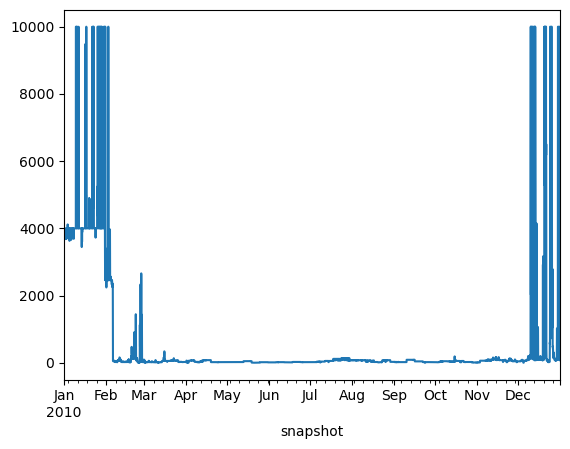

In [55]:
n.buses_t.marginal_price["NOM1"].plot()

In [51]:
print(end - start )

2:00:17.167858


In [32]:
m.statistics.energy_balance(groupby=["bus", "carrier"], groupby_time=False).loc[:, "NON1", :].T.iloc[:7].sum()*24

component    carrier 
Generator    CCGT            22.92696
             OCGT            22.23480
             ROR          25570.99944
             biomass      11894.02944
             load             0.01176
             onwind        2890.21320
Link         AC          -21116.12280
Load         -          -500795.19216
StorageUnit  PHS Open       -32.17992
             hydro       445407.40800
dtype: float64

In [33]:
n.statistics.energy_balance(groupby=["bus", "carrier"], groupby_time=False).loc[:, "NON1", :].T.iloc[:7*24].sum()

component    carrier 
Generator    CCGT             2.34794
             OCGT             2.27485
             ROR          42999.86528
             biomass      12173.16045
             load             0.13231
             onwind       74185.08651
Link         AC          -88166.53744
Load         -          -500795.19200
StorageUnit  PHS Open       -11.93367
             hydro       459572.52677
dtype: float64

In [37]:
n.generators_t.p.filter(like="load").sum().sort_values()

name
ESG1_OFF load shedding        0.000000
CY00 load shedding            0.344238
MT00 load shedding            0.344600
MD00 load shedding            0.363273
GR03 load shedding            0.367032
                              ...     
FR00 load shedding            0.600928
SE01 load shedding            0.610273
NLLL_OFF load shedding       31.356876
DKE1 load shedding          846.608972
NOM1 load shedding        14356.728728
Length: 62, dtype: float64

In [168]:
(m.statistics.energy_balance(groupby=["bus", "carrier"], groupby_time=False).loc[:, "NON1", :].T.iloc[:7].sum()*24).subtract(
    n.statistics.energy_balance(groupby=["bus", "carrier"], groupby_time=False).loc[:, "NON1", :].T.iloc[:7*24].sum(),
    fill_value=0    
)

component    carrier 
Generator    CCGT             3.95815
             OCGT             3.92848
             ROR         -17864.47414
             biomass        -82.93865
             load        -80015.09383
             onwind      -69445.35006
Link         AC           12424.32425
Load         -               -0.00016
StorageUnit  PHS Open        25.53005
             hydro       149469.75644
dtype: float64

In [145]:
n.generators_t.p["NON1 gen-shedding"]

snapshot
2010-01-01 00:00:00   -347.306628
2010-01-01 01:00:00   -347.306709
2010-01-01 02:00:00   -347.306727
2010-01-01 03:00:00   -347.306720
2010-01-01 04:00:00   -347.306705
                          ...    
2010-12-31 19:00:00      0.000000
2010-12-31 20:00:00      0.000000
2010-12-31 21:00:00      0.000000
2010-12-31 22:00:00      0.000000
2010-12-31 23:00:00      0.000000
Name: NON1 gen-shedding, Length: 8760, dtype: float64

In [110]:
n.generators_t.p.iloc[:168].filter(like="NON1").sum().sort_values()

name
NON1 gen-shedding        -58347.687718
NON1 OCGT new 2028            0.780926
NON1 OCGT new 2030            0.780926
NON1 OCGT new 2029            0.780926
NON1 CCGT new 2030            0.794693
NON1 CCGT new 2029            0.794693
NON1 CCGT new 2028            0.794693
NON1 biomass exit 2036    12754.473783
NON1 ROR                  42991.202929
NON1 onwind               74167.609129
NON1 load shedding        79985.246821
dtype: float64

In [111]:
m.generators_t.p.filter(like="NON1").iloc[:7].sum()*24

name
NON1 biomass exit 2036    11985.203285
NON1 OCGT new 2028            4.144060
NON1 OCGT new 2029            1.680000
NON1 OCGT new 2030            4.963203
NON1 CCGT new 2028            4.165774
NON1 CCGT new 2029            1.680000
NON1 CCGT new 2030            4.992161
NON1 onwind                4586.988000
NON1 ROR                  24139.239707
NON1 load shedding            0.012171
dtype: float64

In [112]:
m.snapshot_weightings

,objective,stores,generators
snapshot,,,
2010-01-01,24.0,24.0,24.0
2010-01-02,24.0,24.0,24.0
2010-01-03,24.0,24.0,24.0
2010-01-04,24.0,24.0,24.0
2010-01-05,24.0,24.0,24.0
...,...,...,...
2010-12-27,24.0,24.0,24.0
2010-12-28,24.0,24.0,24.0
2010-12-29,24.0,24.0,24.0


<Axes: xlabel='snapshot'>

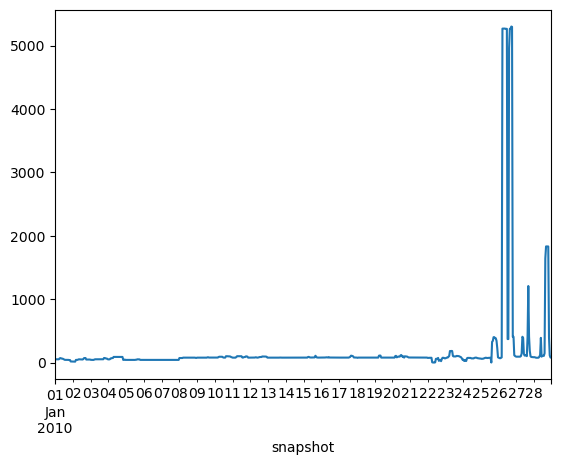

In [44]:
n.buses_t.marginal_price["NON1"].iloc[:168*4].plot()#.sort_values(ascending=False).reset_index(drop=True).plot(ylim=[0,400])

name
AL00 hydro       1720000.00
AT00 PHS            5000.00
AT00 PHS Open    1750000.00
AT00 hydro        800000.00
AT00 pondage       10000.00
                    ...    
SK00 pondage       10000.00
SK00 battery        5000.00
UK00 PHS           20000.00
UK00 battery       43639.78
UKNI battery        5000.00
Length: 129, dtype: float64

name
AL00 hydro       0.0
AT00 PHS         0.0
AT00 PHS Open    0.0
AT00 hydro       0.0
AT00 pondage     0.0
                ... 
SK00 pondage     0.0
SK00 battery     0.0
UK00 PHS         0.0
UK00 battery     0.0
UKNI battery     0.0
Name: state_of_charge_initial, Length: 129, dtype: float64

In [74]:
m.storage_units_t.state_of_charge.div(m.storage_units.p_nom.multiply(m.storage_units.max_hours)).filter(like="NON1")

name,NON1 PHS Open,NON1 hydro
snapshot,,
2010-01-01,0.000003,0.000251
2010-01-02,0.000005,0.001327
2010-01-03,0.000006,0.002405
2010-01-04,0.000007,0.002992
2010-01-05,0.000009,0.004071
...,...,...
2010-12-27,0.003964,0.244203
2010-12-28,0.003959,0.242630
2010-12-29,0.003954,0.240876


<Axes: xlabel='snapshot'>

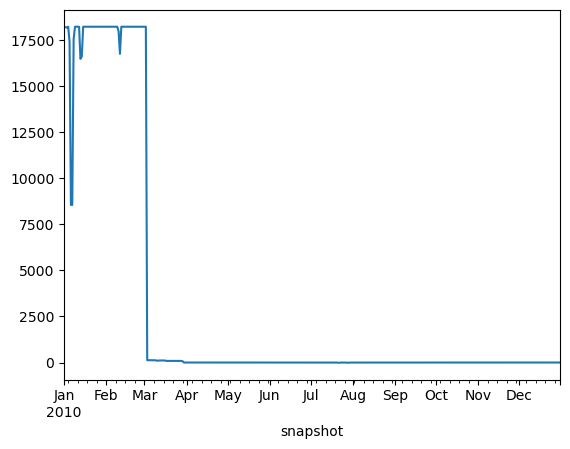

In [66]:
m.buses_t.marginal_price["NON1"

<Axes: xlabel='snapshot'>

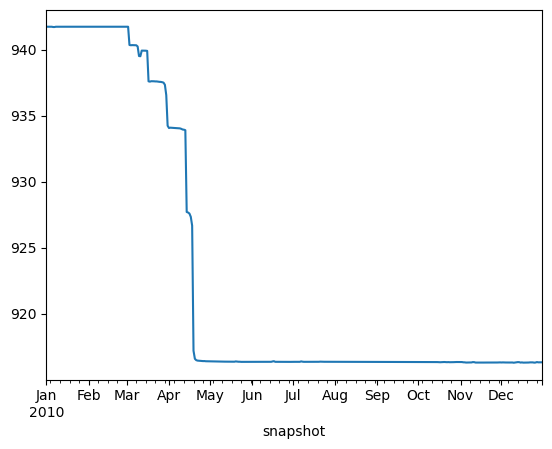

In [62]:
m.generators_t.p.filter(like="NOS3").sum(axis=1).plot()

<Axes: xlabel='snapshot'>

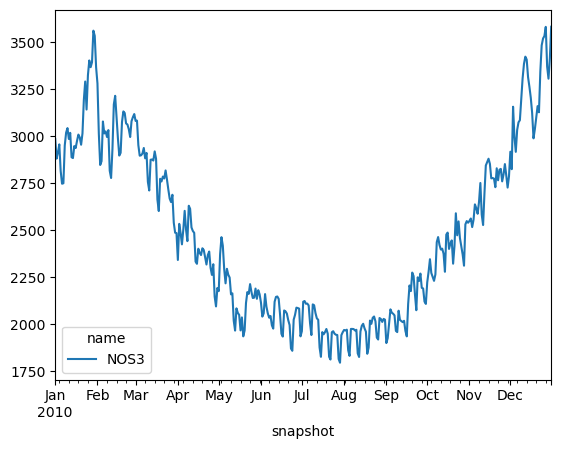

In [60]:
m.loads_t.p_set.filter(like="NOS3").plot()

In [ ]:
dirname = os.path.dirname(solved_network)

In [ ]:
if not os.path.isdir(dirname):
    os.makedirs(dirname)

In [ ]:
def market_revenue(n):
    
    spot_prices = n.buses_t.marginal_price.reindex(n.generators.bus.values, axis=1)

    spot_prices.columns = n.generators.index

    spot_payments = spot_prices.subtract(
        n.generators.marginal_cost
    ).multiply(n.generators_t.p).sum()

    reserve_prices = n.buses_t.mu_reserve_balance.reindex(n.generators.bus.values, axis=1)

    reserve_prices.columns = n.generators.index

    reserve_payments = reserve_prices.multiply(n.generators_t.r).sum()

    return (spot_payments + reserve_payments)

In [ ]:
if not os.path.exists(os.path.dirname(revenues)):
    os.makedirs(os.path.dirname(revenues))

In [ ]:
if not os.path.exists(os.path.dirname(lole)):
    os.makedirs(os.path.dirname(lole))

In [ ]:
market_revenue(n).to_hdf(revenues, "revenues")